# 识别趋势震荡之神器 MESA --最大熵谱分析（一）：滤波器模型建立

### 导入需要的Package

In [2]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/28235
# 标题：识别趋势震荡之神器 MESA最大熵谱分析（一）：滤波器建立

from jqdatasdk import * 
auth('user_name','password')

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
import seaborn as sns
import pandas as pd
import statsmodels.tsa.api as smt

In [4]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [5]:
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

In [6]:
from statsmodels.tsa.api import acf, pacf, graphics

In [7]:
import math

In [19]:
from statsmodels.tsa.stattools import adfuller as ADF

## 取分钟级数据，在可能的情况下尽可能取更细致的数据，避免信息丢失

In [8]:
start_date = '2020-06-01'
end_date = '2020-07-02'

In [9]:
df = get_price('000300.XSHG', start_date = start_date, end_date = end_date, frequency = 'minute')
df

,open,close,high,low,volume,money
2020-06-01 09:31:00,3901.73,3916.87,3917.83,3901.73,472712900.0,6.809592e+09
2020-06-01 09:32:00,3916.79,3923.65,3923.65,3916.79,226349200.0,3.454604e+09
2020-06-01 09:33:00,3924.91,3927.14,3927.37,3924.91,178812600.0,2.848020e+09
2020-06-01 09:34:00,3925.79,3919.52,3925.79,3919.52,163042800.0,2.826398e+09
2020-06-01 09:35:00,3918.91,3921.59,3922.56,3918.22,140899600.0,2.471371e+09
...,...,...,...,...,...,...
2020-07-01 14:56:00,4243.52,4245.06,4245.68,4243.52,123488600.0,1.943141e+09
2020-07-01 14:57:00,4244.97,4247.09,4247.09,4244.97,120538000.0,2.129668e+09
2020-07-01 14:58:00,4247.35,4247.34,4247.35,4247.34,5043000.0,8.953286e+07
2020-07-01 14:59:00,4247.34,4247.34,4247.34,4247.34,0.0,0.000000e+00


/Users/hongrendemac/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


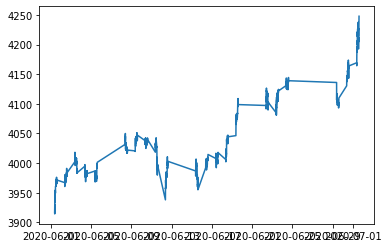

In [10]:
plt.plot(df['close'])

In [11]:
df = df.reset_index()
df

,index,open,close,high,low,volume,money
0,2020-06-01 09:31:00,3901.73,3916.87,3917.83,3901.73,472712900.0,6.809592e+09
1,2020-06-01 09:32:00,3916.79,3923.65,3923.65,3916.79,226349200.0,3.454604e+09
2,2020-06-01 09:33:00,3924.91,3927.14,3927.37,3924.91,178812600.0,2.848020e+09
3,2020-06-01 09:34:00,3925.79,3919.52,3925.79,3919.52,163042800.0,2.826398e+09
4,2020-06-01 09:35:00,3918.91,3921.59,3922.56,3918.22,140899600.0,2.471371e+09
...,...,...,...,...,...,...,...
5035,2020-07-01 14:56:00,4243.52,4245.06,4245.68,4243.52,123488600.0,1.943141e+09
5036,2020-07-01 14:57:00,4244.97,4247.09,4247.09,4244.97,120538000.0,2.129668e+09
5037,2020-07-01 14:58:00,4247.35,4247.34,4247.35,4247.34,5043000.0,8.953286e+07
5038,2020-07-01 14:59:00,4247.34,4247.34,4247.34,4247.34,0.0,0.000000e+00


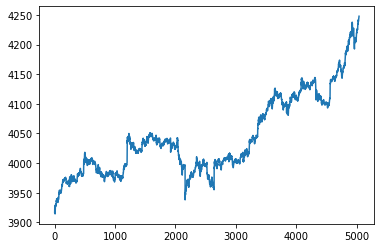

In [12]:
plt.plot(df['close'])

## 使用AR模型估计最大熵谱分析模型的系数，AR模型有效的前提是平稳序列

In [20]:
ADF(df['close'])

(0.23302291698008903,
 0.9740541036168257,
 10,
 5029,
 {'1%': -3.431650982497774,
  '5%': -2.8621148943129975,
  '10%': -2.5670760168145454},
 20743.43331664526)

### 序列不平稳，进行差分

In [21]:
df = df.diff()
df = df.dropna()

In [22]:
ADF(df['close'])

(-23.304706024153177,
 0.0,
 9,
 5029,
 {'1%': -3.431650982497774,
  '5%': -2.8621148943129975,
  '10%': -2.5670760168145454},
 20735.086824018214)

### 序列平稳，对差分数据等间隔取值，选取合适的间隔建立AR模型
### 每天的数据量和AR模型滞后项保持一致

In [23]:
max_range = df.shape[0]

In [24]:
df_40 = pd.DataFrame()
for i in range(0, max_range, 6):
    s = df.iloc[i]
    df_40 = df_40.append(s, ignore_index = True)
df_40_close = df_40['close']
df_40_close

0      6.78
1     -2.50
2      4.24
3      0.64
4      1.86
       ... 
835   -0.13
836    4.40
837   -0.17
838   -0.04
839    1.54
Name: close, Length: 840, dtype: float64

In [25]:
df_30 = pd.DataFrame()
for i in range(0, max_range, 8):
    s = df.iloc[i]
    df_30 = df_30.append(s, ignore_index = True)
df_30_close = df_30['close']

In [26]:
df_20 = pd.DataFrame()
for i in range(0, max_range, 12):
    s = df.iloc[i]
    df_20 = df_20.append(s, ignore_index = True)
df_20_close = df_20['close']

In [27]:
df_10 = pd.DataFrame()
for i in range(0, max_range, 24):
    s = df.iloc[i]
    df_10 = df_10.append(s, ignore_index = True)
df_10_close = df_10['close']

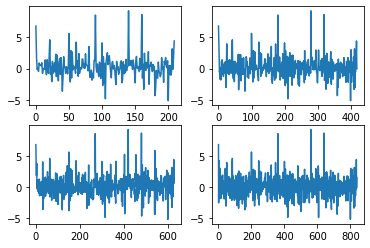

In [28]:
plt.subplot(2, 2, 1)
plt.plot(df_10_close)
plt.subplot(2, 2, 2)
plt.plot(df_20_close)
plt.subplot(2, 2, 3)
plt.plot(df_30_close)
plt.subplot(2, 2, 4)
plt.plot(df_40_close)

In [29]:
def ts_plot(data, lags=None,title=''):
    if not isinstance(data, pd.Series):   
        data = pd.Series(data)
    #matplotlib官方提供了五种不同的图形风格，
    #包括bmh、ggplot、dark_background、fivethirtyeight和grayscale
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        data.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('ACF')
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('PACF')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ')        
        scs.probplot(data, sparams=(data.mean(), 
                     data.std()), plot=pp_ax)
        pp_ax.set_title('PP') 
        plt.tight_layout()
    return

In [30]:
max_lag = 10
Y_10 = df_10['close']

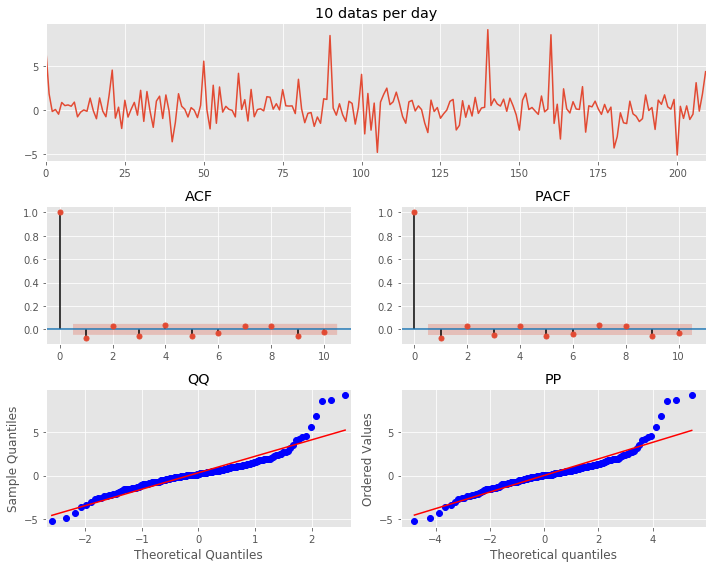

In [31]:
ts_plot(Y_10,lags = max_lag,title = '10 datas per day')

In [32]:
max_lag = 20
Y_20 = df_20['close']

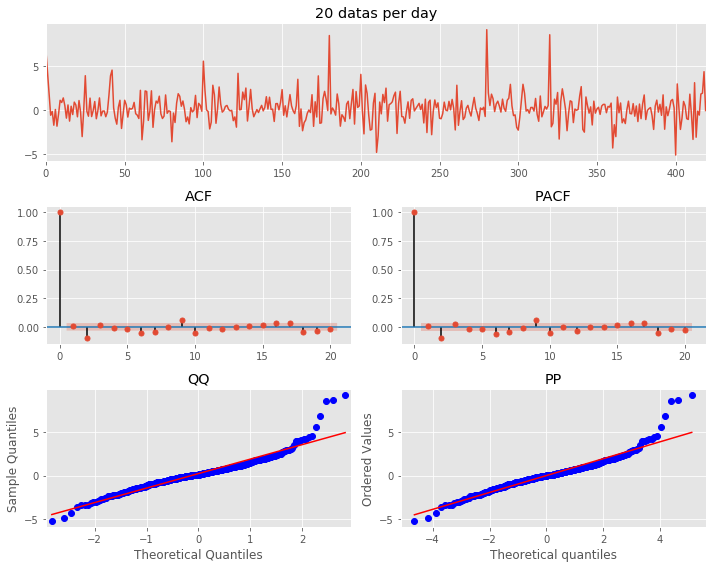

In [33]:
ts_plot(Y_20,lags = max_lag,title = '20 datas per day')

In [34]:
max_lag = 30
Y_30 = df_30['close']

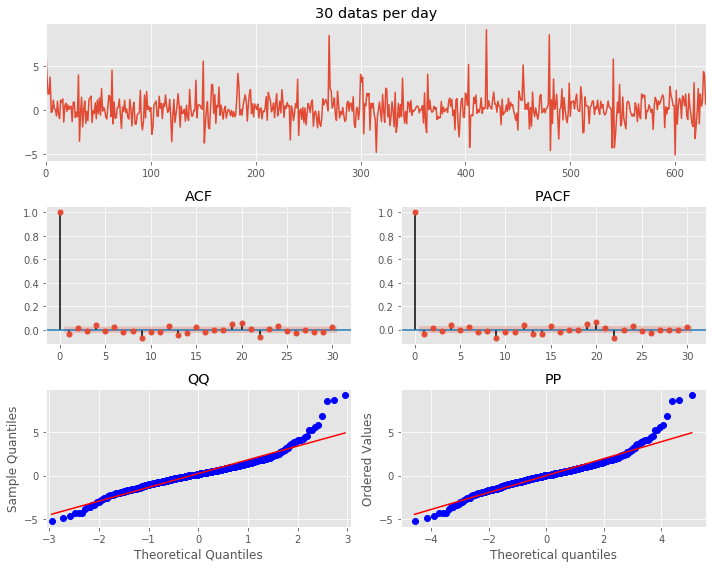

In [35]:
ts_plot(Y_30,lags = max_lag,title = '30 datas per day')

In [36]:
max_lag = 40
Y_40 = df_40['close']

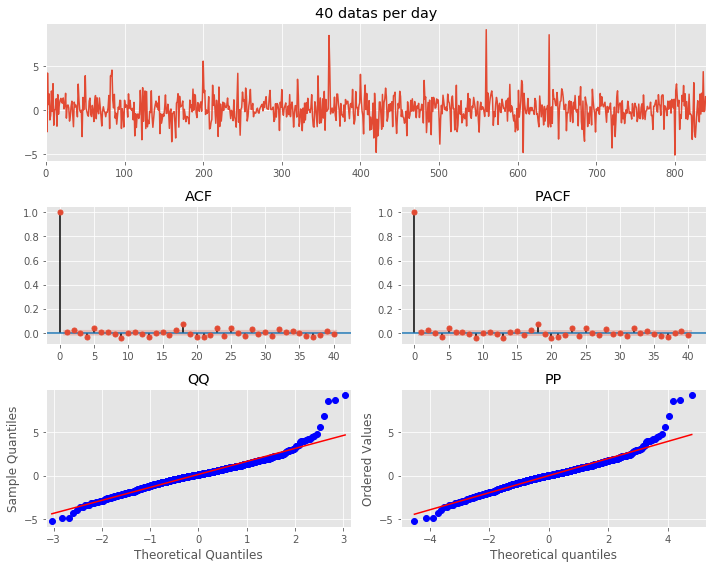

In [37]:
ts_plot(Y_40,lags = max_lag,title = '40 datas per day')

In [38]:
mod = AutoReg(Y_10, 4)
res = mod.fit()
res.aic

1.2634296688312072

### 绘制AIC图像，选取最合适的滞后项数和阶数

In [39]:
aic_10 = []
for i in range(1, 10):
    mod = AutoReg(Y_10, i)
    res = mod.fit()
    aic_10.append(res.aic)
aic_10

[1.2302034421807695,
 1.2378389944223642,
 1.2494292647853802,
 1.2634296688312072,
 1.2741135863364341,
 1.2860008787750306,
 1.2991823149576112,
 1.3136624455192345,
 1.3258292511393062]

In [40]:
aic_20 = []
for i in range(1, 10):
    mod = AutoReg(Y_20, i)
    res = mod.fit()
    aic_20.append(res.aic)
aic_20

[0.9893080395695613,
 0.9716752116028244,
 0.9731276098672895,
 0.9798851731752586,
 0.9868415067081968,
 0.9869073356540701,
 0.991724663789896,
 0.9961171557461387,
 0.9996224644038159]

In [41]:
aic_30 = []
for i in range(1, 10):
    mod = AutoReg(Y_30, i)
    res = mod.fit()
    aic_30.append(res.aic)
aic_30

[0.8883966266408881,
 0.8827051020498194,
 0.8854595770511812,
 0.8863761800597363,
 0.8828383721324863,
 0.8872542839823238,
 0.891697544457208,
 0.8956571815871494,
 0.895290781906864]

In [42]:
aic_40 = []
for i in range(1, 10):
    mod = AutoReg(Y_40, i)
    res = mod.fit()
    aic_40.append(res.aic)
aic_40

[0.7713723717306292,
 0.7703757838399609,
 0.7647320697059775,
 0.7669245156801189,
 0.7668024048259103,
 0.7687842971095048,
 0.7722914903095743,
 0.7736629254886405,
 0.7756862952999102]

In [43]:
x = range(0, 9)
y1 = aic_10
y2 = aic_20
y3 = aic_30
y4 = aic_40

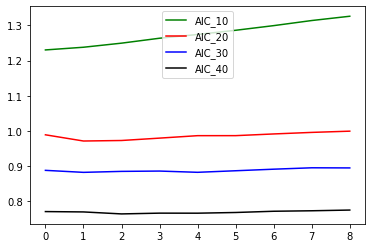

In [44]:
plt.plot(x, y1, color = 'green', label = 'AIC_10')
plt.plot(x, y2, color = 'red', label = 'AIC_20')
plt.plot(x, y3, color = 'b', label = 'AIC_30')
plt.plot(x, y4, color = 'black', label = 'AIC_40')
plt.legend()

### 显然滞后项为40最为合适，目测估计是AR（2）模型，（理论上ARMA（1，1）模型更好，但是无法转化为最大熵模型），接下来用statsmodel的package进行检验

In [45]:
result = smt.AR(Y_40).fit(maxlag=40, ic='aic', trend='nc')
est_order = smt.AR(Y_40).select_order(maxlag=40, 
            ic='aic', trend='nc')
print(f'沪深300拟合AR模型的最佳滞后阶数 {est_order}')

/Users/hongrendemac/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN,

沪深300拟合AR模型的最佳滞后阶数 1


### 这里显示最佳滞后阶数是1，但是如果是1，频谱密度将为一个常数，所以选择最接近的2，建立AR（2）模型

In [46]:
mod = AutoReg(Y_40, 2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  close   No. Observations:                  840
Model:                     AutoReg(2)   Log Likelihood               -1507.858
Method:               Conditional MLE   S.D. of innovations              1.463
Date:                Fri, 03 Jul 2020   AIC                              0.770
Time:                        09:24:35   BIC                              0.793
Sample:                             2   HQIC                             0.779
                                  840                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1342      0.051      2.632      0.008       0.034       0.234
close.L1       0.0162      0.034      0.471      0.638      -0.051       0.084
close.L2       0.0218      0.034      0.640      0.522      -0.045       0.089
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.4099           +0.0000j            6.4099            0.0000
AR.2           -7.1540           +0.0000j            7.1540            0.5000
-----------------------------------------------------------------------------
"""

In [47]:
phi1 = res.params[1]
phi2 = res.params[2]
phi1

0.016226931041860834

In [48]:
phi2

0.021807343639551807

### 通过Z变换得到需要的alpha系数

In [49]:
alpha1 = phi1
alpha2 = phi2

In [50]:
alpha = np.array([alpha1, alpha2])
sigma = alpha.std()
sigma

0.0027902062988454865

In [51]:
pi = math.pi
pi

3.141592653589793

In [52]:
e = math.e
e

2.718281828459045

In [53]:
np.exp(complex(1,5))

(0.7710737641656675-2.6066264306850795j)

In [54]:
f = np.linspace(0, 0.5, 1000)

In [55]:
s = lambda f : (2*sigma)/(abs(1 - alpha1*np.exp(complex(0,-1*2*pi*f)) - alpha2*np.exp(complex(0,-4*pi*f))))**2

In [56]:
s(0.8)-s(0.2)

0.0

In [57]:
spectral_density = map(s, f)

In [58]:
spectral_density = list(spectral_density)
spectral_density

[0.006030413793974559,
 0.006030407149450455,
 0.006030387216198488,
 0.006030353995179658,
 0.006030307487995543,
 0.006030247696888164,
 0.006030174624739787,
 0.006030088275072694,
 0.006029988652048866,
 0.006029875760469644,
 0.006029749605775318,
 0.0060296101940446635,
 0.006029457531994422,
 0.006029291626978751,
 0.0060291124869885785,
 0.00602892012065094,
 0.006028714537228247,
 0.006028495746617495,
 0.0060282637593494426,
 0.006028018586587701,
 0.006027760240127808,
 0.006027488732396225,
 0.006027204076449289,
 0.006026906285972104,
 0.006026595375277399,
 0.0060262713593043134,
 0.006025934253617141,
 0.0060255840744040156,
 0.0060252208384755585,
 0.0060248445632634555,
 0.006024455266818995,
 0.006024052967811555,
 0.006023637685527032,
 0.0060232094398662275,
 0.0060227682513431776,
 0.0060223141410834366,
 0.0060218471308223125,
 0.006021367242903047,
 0.00602087450027495,
 0.006020368926491488,
 0.006019850545708308,
 0.006019319382681249,
 0.006018775462764261,
 0

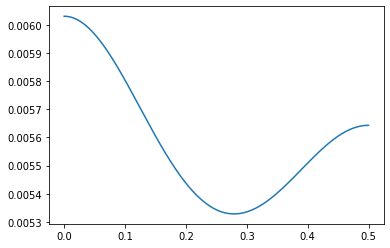

In [59]:
plt.plot(f, spectral_density)

## 以1为周期的偶函数，我们只取正的部分，从0到0.5，函数形状由alpha决定，alpha1比较大，是单峰，大周期，是趋势，alpha比较大，是双峰，小周期是震荡

In [60]:
alpha1 = 0.05
alpha2 = -0.1

In [61]:
alpha = np.array([alpha1, alpha2])
sigma = alpha.std()
sigma

0.07500000000000001

In [62]:
s = lambda f : (2*sigma)/(abs(1 - alpha1*np.exp(complex(0,-1*2*pi*f)) - alpha2*np.exp(complex(0,-4*pi*f))))**2

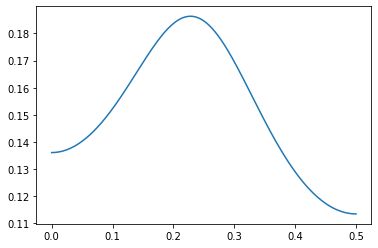

In [63]:
spectral_density = map(s, f)
spectral_density = list(spectral_density)
plt.plot(f, spectral_density)

In [66]:
max(spectral_density)

0.18634975360316727

### 选取频谱密度最大的点作为频率

In [69]:
max_index = spectral_density.index(max(spectral_density))

In [70]:
f = max_index / 1000 * 0.5

In [71]:
T = 1/f

In [72]:
T

4.385964912280701

# 可以直接运行的滤波器函数，输入当前时间，输出当前期货价格对应周期的大小

In [ ]:
now = datetime.datetime.now()

In [ ]:
def Filter(now):
    time_delta = datetime.timedelta(weeks=4, days=0, hours=0, minutes=0,  seconds=0)
    start_date = now - time_delta
    end_date = now
    df = get_price('000300.XSHG', start_date = start_date, end_date = end_date, frequency = 'minute')
    df = df.reset_index()
    df = df.diff()
    df = df.dropna()
    max_range = df.shape[0]
    df_40 = pd.DataFrame()
    for i in range(0, max_range, 6):
        s = df.iloc[i]
        df_40 = df_40.append(s, ignore_index = True)
    max_lag = 40
    Y_40 = df_40['close']
    mod = AutoReg(Y_40, 2)
    res = mod.fit()
    phi1 = res.params[1]
    phi2 = res.params[2]
    alpha1 = phi1
    alpha2 = phi2
    alpha = np.array([alpha1, alpha2])
    sigma = alpha.std()
    pi = math.pi
    f = np.linspace(0, 0.5, 1000)
    spectrum = lambda f : (2*sigma)/(abs(1 - alpha1*np.exp(complex(0,-1*2*pi*f)) - alpha2*np.exp(complex(0,-4*pi*f))))**2
    spectral_density = map(spectrum, f)
    spectral_density = list(spectral_density)
    #plt.plot(f, spectral_density) #画图
    max_index = spectral_density.index(max(spectral_density))
    f_max = max_index / 1000 * 0.5
    if (f_max == 0):
        T = math.inf
    else:
        T = 1/f_max
    return T

In [ ]:
Filter(now)